In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

In [2]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

/home/alex/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# install this specific version
#! pip install albumentations==0.5.2

In [4]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

In [5]:
def generate_label(obj):
    # only have ships
    return 0 

In [6]:
def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "xml")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))


        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}

        # need to fix issues with images without any targets
        if len(boxes) == 0 or len(labels) == 0:
            target['boxes'] = torch.zeros((0,4),dtype=torch.float32)
        else:
            target["boxes"] = boxes
            target["labels"] = labels
        
        return target


In [7]:
class ShipDataset:
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'

        img_path = os.path.join(self.path, file_image)
        label_path = os.path.join("annotations/", file_label)
        
          
        # Read an image with OpenCV, gray scale
        image = cv2.imread(img_path,0)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = torch.tensor(image,dtype=torch.float32)
        image = torch.unsqueeze(image, dim=0)
        target = generate_target(label_path)

        #start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            #total_time = (time.time() - start_t)
            image = augmented['image']
        
            
        return image, target #, total_time

In [8]:
albumentations_transform_oneof = albumentations.Compose([
    #albumentations.Resize(300, 300), 
    #albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    # albumentations.OneOf([
    #                       albumentations.MotionBlur(p=1),
    #                       albumentations.OpticalDistortion(p=1),
    #                       albumentations.GaussNoise(p=1)                 
    # ], p=1),
    albumentations.pytorch.ToTensor()
])

In [9]:
dataset = ShipDataset(
    path = 'images/'
)

In [10]:
len(dataset)

8997

In [11]:
train_set, val_set = torch.utils.data.random_split(dataset, [6000,2997])

In [12]:
len(train_set), len(val_set)

(6000, 2997)

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4,collate_fn=collate_fn)

In [15]:
train_set[0]

(tensor([[[27., 19., 23.,  ..., 26., 24., 20.],
          [22., 16., 15.,  ..., 20., 21., 24.],
          [22., 17., 15.,  ..., 26., 30., 30.],
          ...,
          [25., 23., 21.,  ..., 14., 17., 22.],
          [22., 18., 16.,  ..., 14., 15., 20.],
          [23., 17., 18.,  ..., 15., 15., 18.]]]),
 {'boxes': tensor([], size=(0, 4))})

In [16]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 1, weights=False, pretrained_backbone = True)


/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_loader)

# about 4 min per epoch on Colab GPU
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        
        #print(targets)
        

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        print(images)
        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

[tensor([[[27., 19., 23.,  ..., 26., 24., 20.],
         [22., 16., 15.,  ..., 20., 21., 24.],
         [22., 17., 15.,  ..., 26., 30., 30.],
         ...,
         [25., 23., 21.,  ..., 14., 17., 22.],
         [22., 18., 16.,  ..., 14., 15., 20.],
         [23., 17., 18.,  ..., 15., 15., 18.]]]), tensor([[[ 79.,  79.,  58.,  ..., 190., 168., 153.],
         [ 83.,  83.,  70.,  ..., 155., 151., 172.],
         [ 82.,  75.,  67.,  ..., 131., 132., 159.],
         ...,
         [139., 114., 118.,  ...,  54.,  54.,  47.],
         [148., 133., 140.,  ...,  58.,  47.,  44.],
         [163., 162., 186.,  ...,  43.,  45.,  57.]]]), tensor([[[ 53.,  61.,  61.,  ...,  52.,  58.,  55.],
         [ 55.,  60.,  65.,  ...,  65.,  68.,  63.],
         [ 43.,  49.,  63.,  ...,  69.,  68.,  68.],
         ...,
         [103.,  93.,  78.,  ...,  71.,  69.,  79.],
         [110., 101.,  71.,  ...,  64.,  54.,  70.],
         [ 92.,  87.,  74.,  ...,  58.,  45.,  60.]]]), tensor([[[28., 17., 22.,  ...,

KeyError: 'labels'

##### Augmentations

##### Visualization

In [4]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    # only have ships
    return 0 

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0


def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

##### Albumenations

In [10]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']
        
            
        return image, target, total_time

In [11]:
# transforming the dataset with albumenations
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.pytorch.transforms.ToTensor()
])

In [12]:
albumentations_transform_oneof = albumentations.Compose([
    #albumentations.Resize(300, 300), 
    #albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    # albumentations.OneOf([
    #                       albumentations.MotionBlur(p=1),
    #                       albumentations.OpticalDistortion(p=1),
    #                       albumentations.GaussNoise(p=1)                 
    # ], p=1),
    albumentations.pytorch.ToTensor()
])

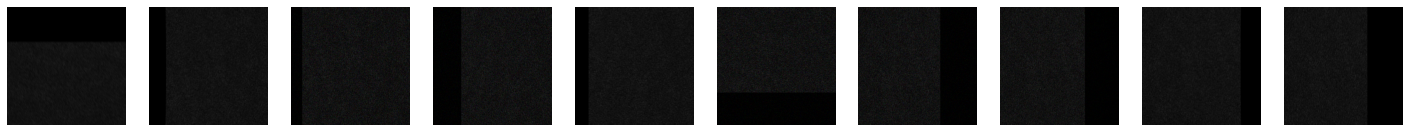

In [13]:
albumentation_dataset_oneof = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')


#### Augmentation for Image AND BBox

In [13]:
class ShipDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        target = generate_target(label_path)

        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}

        # change to tensor
        img = torch.Tensor(image)


        return img, target

In [14]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
     albumentations.pytorch.transforms.ToTensor()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

In [17]:
dataset = ShipDataset(
    path = 'images/',
    transform = bbox_transform
)


In [18]:
img, annot = dataset[1000]
plot_image_from_output(img, annot)

NotImplementedError: Method apply_to_bbox is not implemented in class OpticalDistortion

In [75]:
dataset.label

AttributeError: 'ShipDataset' object has no attribute 'label'

In [65]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4)

In [67]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 1, pretrained=False, pretrained_backbone = True)


/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent

In [68]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

# about 4 min per epoch on Colab GPU
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

/home/alex/.local/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


RuntimeError: each element in list of batch should be of equal size